# The Grand Tour Alogrithm and Applications to Machine Learning

Libraries used in this analysis:

In [1]:
import numpy as np
import pandas as pd
import time
import sklearn
import ipywidgets as widgets
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
from mlxtend.plotting import plot_decision_regions
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC,LinearSVC

%matplotlib inline
%matplotlib notebook

Read in the data, by giving the path (& change seperator if needed):

In [2]:
path = "/home/dom/Documents/MPhys/TheGrandTour/wine_data.txt"
readdata = pd.read_csv(path, sep="\t", header=None);

Now seperate out the classification feature from the data, and then make the classes.

In [4]:
data = np.array(readdata);
data = np.delete(data, 0, 0)
data = data.astype(float)
data = np.swapaxes(data,0,1)


# Need to seperate the classification dimension:
classification = data[13]
data = np.delete(data, 13, axis=0)


# make list of colours for each number:
data_colour = []
for i in range(len(classification)):
    if classification[i] == 1:
        data_colour.append("r")
    elif classification[i] == 2:
        data_colour.append("b")
    elif classification[i] == 3:
        data_colour.append("g")

# Normalizes the data        
for i in range(0, np.shape(data)[0]):
    data[i,:] = (data[i,:] / np.ndarray.max(data[i,:])) * 2 - 1
    

Set the number of timesteps for the grand tour and the step size.

In [5]:
# Variables
stepSize = 0.01
nSteps = 10000

The cell below contains the functions used in the grand tour, and then calculates the data for the grand tour.

In [6]:
def getAlpha(d):
    """
    NEEDS IMPLEMENTATION
    Should produce 1xd(d-1)/2 array of position in grand tour.
    """
    p = d*(d-1)/2     
    primeList = []
    count = 1
    while len(primeList) < p:
        count += 1
        primeBool = False
        for i in range(2, count - 1):
            if count % i == 0:
                primeBool = True
        if primeBool == False:
            irrational = (np.sqrt(count)%1)
            primeList.append(irrational)
            
    primeList = np.asarray(primeList)
    primeList = primeList.dot(stepSize)
    """
    Irrational number generation using exponentials, not being used
    p = int(d*(d-1)/2)
    alpha = np.zeros(p) #alpha(t) parameters defining grand tour in G2,d
    for i in range(0,p):
        alpha[i] = (np.exp(i) % 1) * 2 * np.pi
        
    alpha = alpha.dot(0.001)
    """
    
    
    return primeList


def getAngles(alpha,d):
    """""
    Inputs: 
    alpha = 1xd(d-1)/2 array defining position on grand tour
    d = dimensions of data
    Outputs a dxd array of angles required for the transformation
    """
    theta = np.zeros((d,d));
    i = 0;
    k = 0;
    
    while i < d-1:
        j = i + 1;
        
        while j < d:
            theta[i][j] = alpha[k];
            j += 1;
            k += 1;
    
        i+= 1;
        
    return theta;


def RotationMatrix(i, j, d, theta):
    """
    Inputs:
    i = first indicie of rotating plane
    j = second indicie of rotating plane
    d = dimensions of data
    theta = dxd array of angle of rotation of rotating plane
    Outputs a rotating matrix to rotate plane of ixj plane by theta_ij
    """
    R = np.identity(d)
    R[i,i] = np.cos(theta)
    R[i,j] = -1*np.sin(theta)
    R[j,i] = np.sin(theta)
    R[j,j] = np.cos(theta)
    return R


def BetaFn(d, theta):
    """
    Inputs:
    d = dimensions of data
    theta = dxd array of angle of rotation ixj plane
    Outputs the full matrix transformation for all rotations
    """
    b = RotationMatrix(1, 2, d, theta[1,2])
    i = 1
    j = 2
    for i in range(d):
        for j in range(d):
            if j <= i:
                continue
            if i==1 and j==2:
                continue
            b = np.matmul(b, RotationMatrix(i, j, d, theta[i,j]))
            
    return b


def GrandTour(data, nSteps):
    """
    Inputs:
    data = array of data points, dimensions x npoints
    Outputs a 3D array number of points x t x dimensions, where t
    the time step at that point in the tour
    """

    d = np.shape(data)[0] #dimensions of data
    nPoints = np.shape(data)[1] #number of data points
    tData = np.zeros((nSteps,d,nPoints)) #initialise 3d matrix to store stransforemd data at each timestep
    tBeta = np.zeros((nSteps,d,d))
    Alpha = getAlpha(d)

    
    for t in range(0, nSteps):
        
        
        alpha = Alpha.dot(t)
        theta = getAngles(alpha, d)
        b = BetaFn(d, theta)
        a = np.matmul(b, data)
        tData[t,:,:] = a
        tBeta[t,:,:] = b
        
    return tData, tBeta


tData, tBeta = GrandTour(data, nSteps)

### The Grand Tour:
Move the slider to change through the timesteps, or use arrow keys when slider is selected.

In [8]:
def plot_func(timestep):
    xData = tData[int(timestep)][0]
    yData = tData[int(timestep)][1]
    nData = np.vstack((xData, yData)).T

    plt.figure(figsize=(12,8))
    plt.title("The Grand Tour")
    plt.scatter(xData, yData, color = data_colour)
    plt.show()
    
    
interact(plot_func, timestep = widgets.FloatSlider(value=1,
                                                   min=0,
                                                   max=9999,
                                                   step=1))


interactive(children=(FloatSlider(value=1.0, description='timestep', max=9999.0, step=1.0), Output()), _dom_cl…

<function __main__.plot_func(timestep)>

### The grand tour with the SVM boundaries and accuracy score:

In [9]:
def plot_func(timestep):
    xData = tData[int(timestep)][0]
    yData = tData[int(timestep)][1]
    nData = np.vstack((xData, yData)).T

    #plt.scatter(xData, yData, color = data_colour)
    #plt.show()
    
    clf = OneVsRestClassifier(SVC(kernel='linear'), n_jobs=-1)
    clf.fit(nData, classification)
    plt.figure(figsize=(12,8))
    plot_decision_regions(X=nData, 
                          y=classification.astype(np.integer),
                          clf=clf, 
                          legend=0)
    print("SVM accuracy: "+ str(clf.score(nData, classification)))
    
interact(plot_func, timestep = widgets.FloatSlider(value = 1,
                                                   min = 0,
                                                   max = nSteps - 1,
                                                   step = 1))

interactive(children=(FloatSlider(value=1.0, description='timestep', max=9999.0, step=1.0), Output()), _dom_cl…

<function __main__.plot_func(timestep)>

#### To analyse the SVM lets plot the accuracy of the SVM at each timestep, and also find the max SVM accuracy.

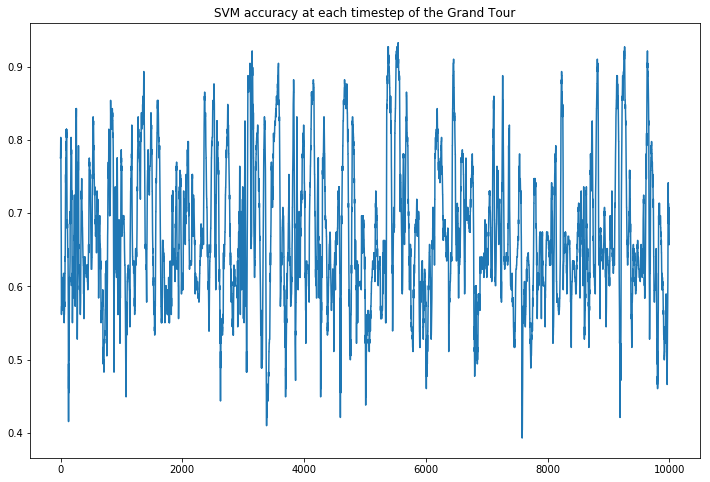

Max SVM accuracy of: 0.9325842696629213
At timestep: 5546


In [58]:
plt.figure(figsize=(12,8))
plt.title("SVM accuracy at each timestep of the Grand Tour")
plt.plot(list(range(len(accuracy))), accuracy, '-', marker=" ")
plt.show()

max_accuracy = [i for i, j in enumerate(accuracy) if j == max(accuracy)]

print("Max SVM accuracy of: " + str(max(accuracy)))
print("At timestep: " + str(max_accuracy[0]))

## Neural Network

Need to convert the classification data into a vector with a 1 in the row representing the class

In [ ]:
# Make a vector for the classification (used for the Neural Network)
targetData = np.zeros((len(tData[0][0]), 3))
for counter, i in enumerate(classification):
    targetData[counter][int(i-1)] = 1